In [1107]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.optimize
from scipy.optimize import curve_fit
import os

From A Phillips and ZY Weinberg. Fits Kd to tite-seq data using mean bin approach and plots estimated mean log fluorescence and fit curve. 
See: https://github.com/amphilli/CH65-comblib/tree/main/Kd_Inference

In [1108]:
counts_table_path = '/Users/stephaniecrilly/test/count_table.csv'
counts_table = pd.read_csv(counts_table_path, sep='\t')

flow_table_path = '/Users/stephaniecrilly/test/flow_table.csv'
flow_table = pd.read_csv(flow_table_path)

outdir = '/Users/stephaniecrilly/Kortemme_lab/helix_sliding/figures'

if not os.path.exists(outdir):
   os.makedirs(outdir)

In [1109]:
counts = (pd.read_csv(counts_table_path, sep='\t')
          .rename({'design':'geno'}, axis=1)
          .replace([np.inf, -np.inf], np.nan)
          .dropna())
fluor = (pd.read_csv(flow_table_path, sep=',', index_col=0)
         .rename({'sample_id': 'sample_name',
                  'mean_log10_APC': 'mean_log10_PEs',
                  'std_log10_APC': 'std_log10_PEs'}, axis=1)
         .replace([np.inf, -np.inf], np.nan)
         .dropna())
sample_info = fluor[['sample_name', 'concentration', 'concentration_float', 'bin', 'cell count']]
sample_info.concentration_float = -1*np.log10(sample_info.concentration_float*1e-12)
fluor = fluor[['sample_name', 'concentration', 'bin', 'mean_log10_PEs', 'std_log10_PEs']]

/var/folders/7h/sws1byhj2pzb__hgp1w6_3j80000gn/T/ipykernel_57691/3845087144.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_info.concentration_float = -1*np.log10(sample_info.concentration_float*1e-12)


In [1110]:
def extractKd(concentrations, bins_mean, bins_std):
    """
        Arguments: concentrations and exponential mean bin numbers (bin number: 1, 2, 3, 4)
        Return: -log10(Kd), and the r^2
    """
    popt, pcov = scipy.optimize.curve_fit(sigmoid, concentrations,
                                          bins_mean,
                                          p0=[(-9), 10**(4), 10**(2)],
                                          sigma=bins_std, absolute_sigma=True,
                                          bounds=[(-12,
                                                   100,
                                                   1),
                                                  (-7,
                                                   1000000,
                                                   100000)],
                                          maxfev=400000)
    return(-1*popt[0], popt[1], popt[2], 1 - np.sum((sigmoid(concentrations, *popt) - bins_mean)**2)/np.sum((bins_mean - bins_mean.mean())**2), np.sqrt(np.diag(pcov))[0])


def sigmoid(c, Kd, A, B):
    return np.log10(A * (10**c/((10**c)+(10**Kd))) + B)


def compute_Kds(sample_info, fluor, df):
    sample_info = sample_info[~sample_info.concentration_float.isna()].copy()
    nb_bins = sample_info.bin.nunique()
    nb_concs = sample_info.concentration.nunique()
    concentrations = sample_info.concentration_float.unique()
    nb_genos = len(df)
    probas = np.zeros((nb_bins, nb_genos, nb_concs))
    counts = np.zeros((nb_bins, nb_genos, nb_concs))
    cells = np.zeros((nb_bins, nb_concs))
    meanfluor, stdfluor = np.zeros((2, nb_bins, nb_concs))
    for gate, conc in zip(sample_info['bin'],
                                      sample_info['concentration']):
        counts[gate-1, :, conc-1] = df[f"r1-hs-{conc}-{gate}"]
        cells[gate-1, conc-1] = sample_info[(sample_info.concentration == conc)
                                    & (sample_info.bin == gate)]["cell count"].iloc[0]
        meanfluor[gate-1, conc-1] = fluor[(fluor.concentration == conc)
                                  & (fluor.bin == gate)]["mean_log10_PEs"].iloc[0]
        stdfluor[gate-1, conc-1] = fluor[(fluor.concentration == conc)
                                 & (fluor.bin == gate)]["std_log10_PEs"].iloc[0]

    probas = counts / (counts.sum(axis=1)[:, None, :]) * cells[:, None, :]
    probas[np.isnan(probas)] = 0.
    probas = probas / probas.sum(axis=0)[None, :, :]
    mean_log10_fluor = (probas * meanfluor[:, None, :]).sum(axis=0)
    std_log10_fluor = np.sqrt((stdfluor[:, None, :]**2 * probas**2
                               + meanfluor[:, None, :]**2 * probas**2 / (1e-22 + counts)).sum(axis=0))

    # replace the "0" concentration by an arbitrary large value (here 20) and invert the values
    concentrations = -concentrations
    concentrations[concentrations ==
                   0] = concentrations[concentrations == 0] - 20
    # fit of Kd
    Kds, A, B, err, cov = np.zeros((5, nb_genos))
    for s in range(nb_genos):
        notnanindex = [ii for ii in range(nb_concs)
                       if not np.isnan(mean_log10_fluor[s, ii] + std_log10_fluor[s, ii])]
        if len(notnanindex) < 4:
            Kds[s], A[s], B[s], err[s], cov[s] = [np.nan]*5
        # not enough reads
        Kds[s], A[s], B[s], err[s], cov[s] = extractKd(concentrations[notnanindex],
                                                           mean_log10_fluor[s,
                                                                            notnanindex],
                                                           std_log10_fluor[s, notnanindex])

    return Kds, A, B, err, cov, mean_log10_fluor, std_log10_fluor, concentrations


In [1111]:
Kds, As, Bs, errs, covs, mean_log10_PE, std_log10_PE, concs = compute_Kds(
        sample_info, fluor, counts)

/var/folders/7h/sws1byhj2pzb__hgp1w6_3j80000gn/T/ipykernel_57691/230672906.py:44: RuntimeWarning: invalid value encountered in divide
  probas = counts / (counts.sum(axis=1)[:, None, :]) * cells[:, None, :]
/var/folders/7h/sws1byhj2pzb__hgp1w6_3j80000gn/T/ipykernel_57691/230672906.py:46: RuntimeWarning: invalid value encountered in divide
  probas = probas / probas.sum(axis=0)[None, :, :]


In [1112]:
okay_fits = np.flatnonzero(errs>0.7)

In [1113]:
counts.loc[okay_fits,'geno']
print(f'{len(okay_fits)}/{len(errs)} fits have r^2 > 0.7')

60/97 fits have r^2 > 0.7


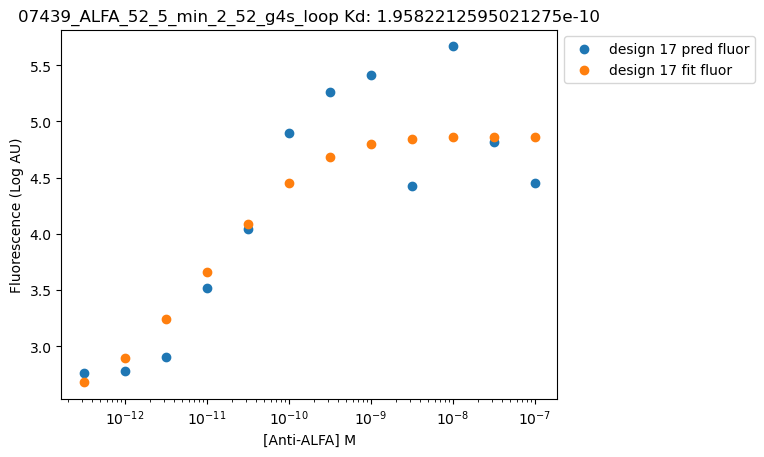

In [1114]:
okay_fits = np.flatnonzero(errs>0.7)
design = np.random.choice(okay_fits, size=1)[0]
design_name = counts.loc[design,'geno']
concentrations = (np.sort(np.unique(sample_info.concentration_float)))[::-1]

plt.scatter(np.sort(10**-concentrations), mean_log10_PE[design,:][::-1], label=f'design {design} pred fluor')
plt.scatter(np.sort(10**-concentrations), sigmoid(concentrations, Kds[design],As[design],Bs[design])[::-1], label=f'design {design} fit fluor')

plt.xscale('log')
plt.xlabel('[Anti-ALFA] M')
plt.ylabel('Fluorescence (Log AU)')
plt.title(f'{design_name} Kd: {10**-Kds[design]}')
plt.legend(bbox_to_anchor=[1,1])

In [1115]:
okay_fits = np.flatnonzero(errs>0.8)

for i in range(0,len(okay_fits)):
    design = okay_fits[i]
    design_name = counts.loc[design,'geno']
    concentrations = (np.sort(np.unique(sample_info.concentration_float)))[::-1]

    plt.scatter(np.sort(10**-concentrations), mean_log10_PE[design,:][::-1], label='pred fluor')
    plt.scatter(np.sort(10**-concentrations), sigmoid(concentrations, Kds[design],As[design],Bs[design])[::-1], label='fit fluor')

    plt.xscale('log')
    plt.xlabel('[Anti-ALFA] M', fontsize=16)
    plt.ylabel('Fluorescence (Log AU)', fontsize=16)
    plt.title(f'{design_name}\nKd: {10**-Kds[design]}', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(loc='lower right', fontsize=16)
    #plt.savefig(f'{outdir}/tite-seq_fits/{design_name}_fit.png', dpi=300, bbox_inches = 'tight')
    plt.clf()

<Figure size 640x480 with 0 Axes>

In [1116]:
#plot for controls
#create master df with all fit parameters
selected_designs = ['bm01_ALFA_1c', 'bm01_ALFA_t2', 'bm01_ALFA_t3', 'bm01_ALFA_t6']
color_palette = ['cyan', 'red', 'orange', 'green']

for i,j in enumerate(selected_designs):
    design = counts.loc[counts['geno']== f'{j}'].index[0]
    design_name = counts.loc[design,'geno']
    concentrations = (np.sort(np.unique(sample_info.concentration_float)))[::-1]

    plt.scatter(np.sort(10**-concentrations), mean_log10_PE[design,:][::-1], label=f'{design_name}, Kd: {10**-Kds[design]}', color=[color_palette[i]])

plt.xscale('log')
plt.xlabel('[Anti-ALFA] M', fontsize=16)
plt.ylabel('Fluorescence (Log AU)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper center', bbox_to_anchor=[0.5,1.5], fontsize=16)

#plt.show()
#plt.savefig(f'{outdir}/tite-seq_fits/all_controls_pred_fluor.png', dpi=300, bbox_inches = 'tight')
plt.clf()

<Figure size 640x480 with 0 Axes>

                                  geno        Kds             As          Bs  \
0    01034_ALFA_53_7_min_0_53_g4s_loop  -8.586778  125466.650140  536.715153   
1    01934_ALFA_53_4_min_0_53_g4s_loop -10.509625  102613.877054    1.000000   
2    02231_ALFA_53_4_min_0_53_g4s_loop  -8.345119    5554.334956  686.440150   
3   02532_ALFA_53_7_min_0_53_bm01_loop -10.528594   79523.641484    1.000000   
4   02532_ALFA_53_8_min_0_53_bm01_loop -10.603852   82917.892492    1.000000   
..                                 ...        ...            ...         ...   
92              bm01_L2_myc_ALFA_t6_v2  -8.531942    4281.936076  671.568150   
93              bm01_L3_myc_ALFA_t6_v2  -9.785741    4406.135305  598.070208   
94              bm01_L4_myc_ALFA_t6_v2  -8.773835    9855.126211  623.498349   
95              bm01_L5_myc_ALFA_t6_v2  -8.482503    5266.511465  670.988355   
96              bm01_L6_myc_ALFA_t6_v2  -8.916340    4358.255076  718.379071   

        errs      covs design_type  
0 

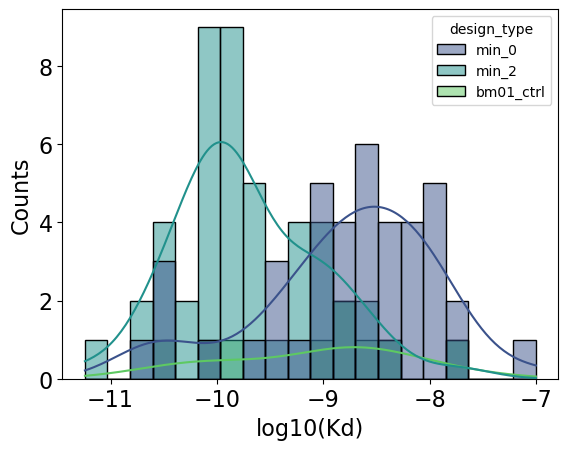

In [1117]:
#histogram of Kds colored by design group
fits = pd.DataFrame({'Kds':Kds, 'As':As, 'Bs':Bs, 'errs':errs, 'covs':covs})
counts_and_fits = pd.concat([counts, fits], axis=1)

counts_and_fits = counts_and_fits[['geno', 'Kds', 'As', 'Bs', 'errs', 'covs']]

#transform Kd
counts_and_fits['Kds'] = -counts_and_fits['Kds']
#print(counts_and_fits)

counts_and_fits_min_type = counts_and_fits['geno'].tolist()

min_type_list = []
for i in counts_and_fits_min_type:
    if 'min_0' in i:
        min_type_list.append('min_0')
    elif 'min_2' in i:
        min_type_list.append('min_2')
    else:
        min_type_list.append('bm01_ctrl')

counts_and_fits['design_type'] = min_type_list

print(counts_and_fits)

sns.histplot(counts_and_fits, x='Kds', bins=20, hue='design_type', palette='viridis', kde=True)
plt.ylabel('Counts', fontsize=16)
plt.xlabel('log10(Kd)', fontsize=16)
#plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig(f'{outdir}/kds_histplot.png', dpi=300, bbox_inches = 'tight')
